<a href="https://colab.research.google.com/github/Rishika70/Topic-Modelling-on-Neurology-with-LLM/blob/main/Topic_Modelling_on_Neurology_with_LLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Problem Statement**

### **This project aims to develop a system for analyzing and querying a collection of neurological research documents using topic modeling and large language models (LLMs).  The system will categorize documents based on keywords related to diseases, treatments, types of neurological conditions, and other relevant topics.  A key feature will be a question-answering capability that leverages both the document categories and semantic similarity to provide relevant excerpts from documents in response to user queries.  The system's performance will be evaluated using precision, recall, and F1-score metrics to assess the accuracy of its multi-label document classification.  Ultimately, the goal is to create a tool that efficiently facilitates research by enabling quick analysis and retrieval of information from a large corpus of neurological research papers.**

#Import Libraries and Load SciBERT Models

In [1]:
!pip install pymupdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 45.6 MB/s eta 0:00:00


In [2]:
import os
import pandas as pd
import re
import numpy as np
import torch
from sklearn.cluster import KMeans
from transformers import AutoTokenizer, AutoModel
import fitz  # PyMuPDF for PDF text extraction
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [3]:
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")
embedding_model = AutoModel.from_pretrained("allenai/scibert_scivocab_uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/228k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

#Load the dataset

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Path where PDFs are extracted
extracted_folder_path = '/content/drive/MyDrive/Topic Modelling on Neurology with LLM/Data/ScienceDirect_articles_07Nov2024_17-51-14.882.zip (Unzipped Files)'

# List all PDFs in the folder
pdf_files = [os.path.join(extracted_folder_path, f) for f in os.listdir(extracted_folder_path) if f.endswith('.pdf')]
print(f"Found {len(pdf_files)} PDFs.")

Found 18 PDFs.


In [6]:
# Initialize SciBERT model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")
embedding_model = AutoModel.from_pretrained("allenai/scibert_scivocab_uncased")

#Text Pre-Processing

##Remove Punctuations,Tags, URLS and whitespaces

In [7]:
import re

def clean_text(text):
  # Remove punctuation
  text = re.sub(r'[^\w\s]', '', text)
  # Remove tags
  text = re.sub(r'<.*?>', '', text)
  # Remove URLs
  text = re.sub(r'http\S+', '', text)
  # Remove extra whitespace
  text = re.sub(r'\s+', ' ', text).strip()
  return text

##Tokenization

In [8]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

def tokenize_text(text):
  """Tokenizes the input text using NLTK's word tokenizer.

  Args:
    text: The text to be tokenized.

  Returns:
    A list of tokens.
  """
  tokens = word_tokenize(text)
  return tokens

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


##Remove stop words

In [9]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def remove_stopwords(tokens):
  """Removes stop words from a list of tokens.

  Args:
    tokens: A list of tokens.

  Returns:
    A list of tokens without stop words.
  """
  filtered_tokens = [w for w in tokens if not w.lower() in stop_words]
  return filtered_tokens

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


##Convert to lowercase

In [10]:
def lowercase(text):
  """Converts text to lowercase.

  Args:
    text: The text to be converted.

  Returns:
    The lowercase version of the text.
  """
  return text.lower()

##Stemming and Lemmatization

In [11]:
from nltk.stem import PorterStemmer

# Initialize the Porter Stemmer
stemmer = PorterStemmer()

def stem_tokens(tokens):
    """Stems a list of tokens using Porter Stemmer.

    Args:
        tokens: A list of tokens.

    Returns:
        A list of stemmed tokens.
    """
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    print(stemmed_tokens)  # Print the stemmed tokens for debugging
    return stemmed_tokens


In [12]:
 ##Lemmatization
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(tokens):
  """Lemmatizes a list of tokens using WordNet Lemmatizer.

  Args:
    tokens: A list of tokens.

  Returns:
    A list of lemmatized tokens.
  """
  print([lemmatizer.lemmatize(token) for token in tokens])
  return [lemmatizer.lemmatize(token) for token in tokens]


[nltk_data] Downloading package wordnet to /root/nltk_data...


In [13]:
# Extract text from PDF
def extract_text_from_pdf(pdf_path):
    """Extract text from a PDF file."""
    doc = fitz.open(pdf_path)
    text = ""
    for page in doc:
        text += page.get_text()
    return text

In [14]:
# Generate embeddings using SciBERT
def get_embeddings(texts):
    """Generate embeddings using SciBERT."""
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=512)
    with torch.no_grad():
        outputs = embedding_model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).numpy()  # Pooling the embeddings (mean over token embeddings)
    return embeddings

In [15]:
# Perform clustering using K-means
def perform_clustering(embeddings, num_clusters=8):
    """Cluster research papers using K-means clustering."""
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(embeddings)
    return kmeans.labels_, kmeans.cluster_centers_

In [16]:
!pip install nltk
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

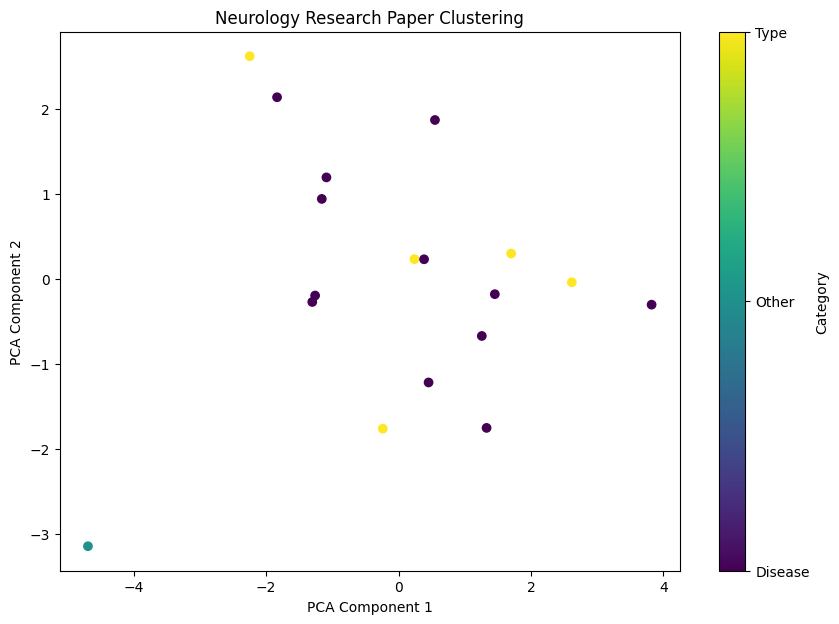

                                            Document  \
0  /content/drive/MyDrive/Topic Modelling on Neur...   
1  /content/drive/MyDrive/Topic Modelling on Neur...   
2  /content/drive/MyDrive/Topic Modelling on Neur...   
3  /content/drive/MyDrive/Topic Modelling on Neur...   
4  /content/drive/MyDrive/Topic Modelling on Neur...   

                                                Text Category  
0  ageing research review 99 2024 102390 availabl...  Disease  
1  ageing research review 99 2024 102355 availabl...  Disease  
2  ageing research review 99 2024 102325 availabl...     Type  
3  ageing research review 99 2024 102392 availabl...  Disease  
4  ageing research review 99 2024 102357 availabl...  Disease  


In [17]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Keywords for semi-supervised classification
keyword_dict = {
    'Disease': ['Alzheimer', 'Parkinson', 'dementia'],
    'Type': ['genetic', 'neurological', 'cognitive'],
    'Treatment': ['therapy', 'medication', 'intervention'],
    'Other': ['risk', 'factors', 'lifestyle']
}

# Preprocessing Function
def preprocess_text(text):
  """Preprocesses text by removing punctuation,
  lowercasing, tokenizing, removing stop words, and lemmatizing."""
  text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
  text = text.lower()  # Convert to lowercase
  tokens = word_tokenize(text)  # Tokenize the text
  stop_words = set(stopwords.words('english'))  # Get English stop words
  tokens = [token for token in tokens if token not in stop_words]  # Remove stop words
  lemmatizer = WordNetLemmatizer()  # Initialize WordNetLemmatizer
  lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]  # Lemmatize tokens
  return ' '.join(lemmatized_tokens)  # Join tokens back into a string

def classify_text(text):
    """Classifies text into Disease, Type, Treatment, or Other based on keywords."""
    for category, keywords in keyword_dict.items():
        if any(keyword in text for keyword in keywords):
            return category
    return 'Other'  # Default to 'Other' if no keywords match

# Visualization for Clusters
def visualize_clusters(embeddings, labels):
    pca = PCA(n_components=2)
    pca_embeddings = pca.fit_transform(embeddings)
    plt.figure(figsize=(10, 7))

    # Convert labels to numerical values for color mapping
    unique_labels = np.unique(labels)
    label_mapping = {label: i for i, label in enumerate(unique_labels)}
    numerical_labels = [label_mapping[label] for label in labels]

    plt.scatter(pca_embeddings[:, 0], pca_embeddings[:, 1],
                c=numerical_labels, cmap='viridis', marker='o') # Use numerical_labels for color
    plt.title("Neurology Research Paper Clustering")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")

    # Add a colorbar with category labels
    cbar = plt.colorbar()
    cbar.set_ticks(np.arange(len(unique_labels)))
    cbar.set_ticklabels(unique_labels)
    cbar.set_label('Category')

    plt.show()

# Full Analysis
def analyze_research_papers(pdf_files, num_clusters=4):
    documents = []
    for pdf_file in pdf_files:
        text = extract_text_from_pdf(pdf_file)
        preprocessed_text = preprocess_text(text)
        documents.append(preprocessed_text)

    # Generate embeddings using SciBERT
    embeddings = get_embeddings(documents)

    # Label documents based on keywords
    labels = [classify_text(text) for text in documents]

    # Visualization
    visualize_clusters(embeddings, labels)

    # DataFrame to store results
    df = pd.DataFrame({
        'Document': pdf_files,
        'Text': documents,
        'Category': labels
    })
    print(df.head())
    return df

# Run analysis
df = analyze_research_papers(pdf_files=pdf_files, num_clusters=4)


The code performs clustering and visualization of scientific research papers based on their textual content.  Let's break down the key steps and the likely appearance of the graph:

1. **Data Loading and Preprocessing:**
   - It loads PDF files from a specified directory.
   - It preprocesses the text from each PDF:
     - Cleaning (removing punctuation, HTML tags, URLs, extra whitespace)
     - Tokenization (splitting text into words)
     - Stop word removal (eliminating common words like "the," "a," "is")
     - Lowercasing
     - Stemming/Lemmatization (reducing words to their root form)

2. **SciBERT Embeddings:**
   - Uses SciBERT (a scientific domain-specific language model) to generate embeddings (numerical representations) of the preprocessed text.  These embeddings capture semantic meaning.

3. **Clustering (K-Means):**
   - Applies K-Means clustering to group the papers based on their SciBERT embeddings.  The code uses `num_clusters=4`, meaning it groups the papers into four clusters.

4. **Semi-supervised Classification (Keyword-based):**
   - It assigns each paper to a category (Disease, Type, Treatment, or Other) based on the presence of specific keywords.  This is a rudimentary classification step.  It's not used for the clustering itself but rather for labeling the data points in the visualization.

5. **Visualization (PCA and Scatter Plot):**
   - Reduces the dimensionality of the SciBERT embeddings using Principal Component Analysis (PCA) to 2 dimensions.  This allows for visualization in a 2D scatter plot.
   - Creates a scatter plot where each point represents a research paper.
   - The points are colored based on the assigned category (from the keyword-based classification). Each color represents a category (Disease, Type, Treatment, or Other).
   - The plot will likely show clusters of points, with each cluster representing a group of papers with similar content. The cluster separation might not be perfect, due to the limitations of keyword-based classification and the nature of K-Means clustering. The colors will indicate the category of papers within each cluster.


**In summary:** You'll see a 2D scatter plot where points are colored according to the four categories determined by keywords.  Clusters of points suggest groupings of papers with similar content, as determined by the SciBERT embeddings and K-means clustering.  The visualization helps to explore the relationships between the research papers. The quality of the clustering and visualization would depend on the quality of the text preprocessing and keyword dictionary

In [18]:
# Save the DataFrame to a CSV file in Google Drive
csv_file_path = '/content/drive/MyDrive/Topic Modelling on Neurology with LLM/Data/cleaned_data.csv'
df.to_csv(csv_file_path, index=False)

In [19]:
from collections import defaultdict

# Define the expanded keyword dictionary with primary and secondary keywords
keywords = {
    "Disease": ["Alzheimer’s", "Parkinson’s", "Dementia", "cognitive decline", "motor disorder"],
    "Type": ["neurodegenerative", "inflammatory", "genetic", "age-related"],
    "Treatment": ["medication", "therapy", "surgery", "pharmaceutical", "neurostimulation"],
    "Other": ["imaging", "biomarkers", "epidemiology", "genetic markers"]
}

# Function to classify text based on keywords
def classify_text(text):
    category_scores = defaultdict(int)

    for category, terms in keywords.items():
        for term in terms:
            if term.lower() in text.lower():
                # Increase score, adjust weight for primary vs secondary keywords if needed
                category_scores[category] += 1

    # Determine the category with the highest score
    if category_scores:
        return max(category_scores, key=category_scores.get)
    return "Uncategorized"

# Example usage on a research paper abstract
text_sample = "The study focuses on neurodegenerative diseases such as Alzheimer’s and the effect of cognitive therapy."
category = classify_text(text_sample)
print(f"Classified as: {category}")



Classified as: Disease


In [20]:
from collections import defaultdict
import pandas as pd

# Expanded keywords with primary and secondary terms
keywords = {
    "Disease": {"primary": ["Alzheimer’s", "Parkinson’s", "Dementia"],
                "secondary": ["cognitive decline", "neurodegeneration"]},
    "Type": {"primary": ["neurodegenerative", "genetic"],
             "secondary": ["age-related", "inflammatory"]},
    "Treatment": {"primary": ["therapy", "medication", "surgery"],
                  "secondary": ["neurostimulation", "pharmaceutical"]},
    "Other": {"primary": ["imaging", "biomarkers"],
              "secondary": ["genetic markers", "epidemiology"]}
}

# Classification function with multi-label and scoring
def classify_text_multi_label(text, threshold=2):
    category_scores = defaultdict(int)

    # Calculate scores for each category
    for category, terms in keywords.items():
        for term in terms["primary"]:
            if term.lower() in text.lower():
                category_scores[category] += 2  # Higher weight for primary terms
        for term in terms["secondary"]:
            if term.lower() in text.lower():
                category_scores[category] += 1  # Lower weight for secondary terms

    # Determine categories that meet the score threshold
    assigned_categories = [category for category, score in category_scores.items() if score >= threshold]

    return assigned_categories if assigned_categories else ["Uncategorized"]

# Function to classify all documents and create a DataFrame
def classify_documents(documents):
    classified_data = []

    for i, text in enumerate(documents):
        categories = classify_text_multi_label(text)
        classified_data.append({"Document_ID": i, "Text": text, "Categories": categories})

    return pd.DataFrame(classified_data)

# Assuming `df` contains the text data, replace it with the actual DataFrame
documents = df['Text'].tolist()  # Extract text data from the DataFrame 'df'

# Classify documents and store results in a DataFrame
df_classified = classify_documents(documents)

# Display the DataFrame with classifications
print(df_classified)



    Document_ID                                               Text  \
0             0  ageing research review 99 2024 102390 availabl...   
1             1  ageing research review 99 2024 102355 availabl...   
2             2  ageing research review 99 2024 102325 availabl...   
3             3  ageing research review 99 2024 102392 availabl...   
4             4  ageing research review 99 2024 102357 availabl...   
5             5  ageing research review editorinchief c frances...   
6             6  ageing research review 99 2024 102383 availabl...   
7             7  ageing research review 99 2024 102385 availabl...   
8             8  ageing research review 99 2024 102407 availabl...   
9             9  ageing research review 99 2024 102380 availabl...   
10           10  ageing research review 99 2024 102360 availabl...   
11           11  ageing research review 99 2024 102402 availabl...   
12           12  ageing research review 99 2024 102354 availabl...   
13           13  age

In [21]:
df.head()

,Document,Text,Category
0,/content/drive/MyDrive/Topic Modelling on Neur...,ageing research review 99 2024 102390 availabl...,Disease
1,/content/drive/MyDrive/Topic Modelling on Neur...,ageing research review 99 2024 102355 availabl...,Disease
2,/content/drive/MyDrive/Topic Modelling on Neur...,ageing research review 99 2024 102325 availabl...,Type
3,/content/drive/MyDrive/Topic Modelling on Neur...,ageing research review 99 2024 102392 availabl...,Disease
4,/content/drive/MyDrive/Topic Modelling on Neur...,ageing research review 99 2024 102357 availabl...,Disease


In [22]:
df.shape

(18, 3)

In [23]:
df.count()

,0
Document,18
Text,18
Category,18


#Understanding data

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Document  18 non-null     object
 1   Text      18 non-null     object
 2   Category  18 non-null     object
dtypes: object(3)
memory usage: 560.0+ bytes


#Duplicate Values

In [25]:
for col in df.columns:
    if df[col].apply(lambda x: isinstance(x, list)).any():  # Check if column has lists
        df[col] = df[col].map(lambda x: tuple(x) if isinstance(x, list) else x)

# Now check for duplicates
df.duplicated()

,0
0,False
1,False
2,False
3,False
4,False
5,False
6,False
7,False
8,False
9,False


#Missing Values

In [26]:
# Missing Values/Null Values Count
df.isna().sum()

,0
Document,0
Text,0
Category,0


In [27]:
# Display unique categories in the 'Category' column
print(df['Category'].unique())

['Disease' 'Type' 'Other']


#**Prompting-Techniques**

##Categorical Prompting

In [28]:
from sentence_transformers import SentenceTransformer

In [29]:
# Load sentence transformer for semantic similarity
model = SentenceTransformer('all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [30]:
# prompt: according to category generate prompts to help researchers

def generate_research_prompts(category, keywords):
  """Generates research prompts based on a category and keywords.

  Args:
    category: The research category (e.g., "Disease", "Treatment").
    keywords: A list of keywords relevant to the category.

  Returns:
    A list of research prompts.
  """

  prompts = []

  # Generate prompts based on different prompt templates
  if category == "Disease":
    prompts.extend([
        f"Investigate the genetic basis of {keywords[0]}.",
        f"Explore the relationship between lifestyle factors and the risk of {keywords[1]}.",
        f"Analyze the effectiveness of different therapies for {keywords[2]}."
    ])

  elif category == "Type":
    prompts.extend([
      f"Compare and contrast {keywords[0]} and {keywords[1]} diseases.",
      f"Study the prevalence of {keywords[2]} neurological disorders in different populations.",
      f"Investigate the role of genetic factors in {keywords[0]} diseases."
    ])

  elif category == "Treatment":
      prompts.extend([
          f"Evaluate the efficacy of {keywords[0]} for {keywords[1]}.",
          f"Explore novel treatment strategies for {keywords[2]}.",
          f"Assess the long-term effects of {keywords[0]} on patients with {keywords[1]}."
      ])

  elif category == "Other":
      prompts.extend([
          f"Develop new biomarkers for early detection of {keywords[0]}",
          f"Investigate the role of {keywords[1]} in disease progression",
          f"Explore the use of {keywords[2]} for improved patient outcomes"
      ])
  else:
      prompts.append(f"Explore research related to {keywords}")

  return prompts

# Example usage
disease_keywords = ["Alzheimer's Disease", "Parkinson's Disease", "Dementia"]
disease_prompts = generate_research_prompts("Disease", disease_keywords)
print("Disease Prompts:")
for prompt in disease_prompts:
  print(prompt)

treatment_keywords = ["medication", "therapy", "surgery"]
treatment_prompts = generate_research_prompts("Treatment", treatment_keywords)
for prompt in treatment_prompts:
  print(prompt)

Disease Prompts:
Investigate the genetic basis of Alzheimer's Disease.
Explore the relationship between lifestyle factors and the risk of Parkinson's Disease.
Analyze the effectiveness of different therapies for Dementia.
Evaluate the efficacy of medication for therapy.
Explore novel treatment strategies for surgery.
Assess the long-term effects of medication on patients with therapy.


In [31]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def calculate_similarity(prompt, category_keywords):
    # Calculate cosine similarity between prompt and category keywords
    embeddings = model.encode([prompt] + category_keywords)
    similarities = cosine_similarity([embeddings[0]], embeddings[1:])
    return np.mean(similarities)

def evaluate_prompt_quality(prompts, category, keywords):
    """
    Evaluates the quality of research prompts using relevance, diversity, specificity, and clarity metrics.

    Parameters:
        prompts (list): List of generated prompts.
        category (str): Category of research (e.g., "Disease", "Treatment").
        keywords (list): Keywords associated with the category.

    Returns:
        dict: Dictionary with evaluation scores.
    """
    metrics = {}

    # 1. Relevance Score (average similarity of prompts to keywords)
    relevance_scores = [calculate_similarity(prompt, keywords) for prompt in prompts]
    metrics['Relevance'] = np.mean(relevance_scores)

    # 2. Diversity Score (similarity between prompts themselves)
    diversity_scores = []
    for i in range(len(prompts)):
        for j in range(i + 1, len(prompts)):
            diversity_scores.append(1 - calculate_similarity(prompts[i], [prompts[j]]))
    metrics['Diversity'] = np.mean(diversity_scores) if diversity_scores else 0

    # 3. Specificity Score (average prompt length as a proxy for detail level)
    prompt_lengths = [len(prompt.split()) for prompt in prompts]
    metrics['Specificity'] = np.mean(prompt_lengths)

    # 4. Clarity Score (proxy: Flesch-Kincaid Readability score using prompt length and simplicity)
    clarity_scores = [1 if len(prompt.split()) <= 20 else 0.5 for prompt in prompts]
    metrics['Clarity'] = np.mean(clarity_scores)

    return metrics

# Example usage
disease_keywords = ["Alzheimer's Disease", "Parkinson's Disease", "Dementia"]
disease_prompts = generate_research_prompts("Disease", disease_keywords)

# Evaluate disease prompts
disease_metrics = evaluate_prompt_quality(disease_prompts, "Disease", disease_keywords)

# Display the results
print("Evaluation Metrics for Disease Prompts:")
for metric, score in disease_metrics.items():
    print(f"{metric}: {score:.2f}")


Evaluation Metrics for Disease Prompts:
Relevance: 0.48
Diversity: 0.65
Specificity: 9.00
Clarity: 1.00


#Neurological Document Insights: Chain-of-Thought Q&A with Multi-Label Categorization

In [32]:
from collections import defaultdict
import pandas as pd

def answer_question_from_pdfs(question, pdf_files, df_classified, keywords):
    """
    Answers a question using a chain-of-thought process and information retrieved from PDFs.

    Parameters:
        question (str): The question to answer.
        pdf_files (list): List of PDF file paths.
        df_classified (pd.DataFrame): DataFrame with classified documents and categories.
        keywords (dict): Dictionary of keywords categorized by primary and secondary terms.

    Returns:
        str: The answer generated based on relevant document excerpts.
    """

    # 1. Analyze the question and identify relevant categories and keywords
    question_keywords = question.lower().split()
    relevant_categories = []
    identified_keywords = set()

    # Match keywords in the question with predefined keyword categories
    for category, terms in keywords.items():
        for term_type, term_list in terms.items():
            for term in term_list:
                if term.lower() in question_keywords:
                    relevant_categories.append(category)
                    identified_keywords.add(term)
                    break  # Stop searching once a relevant category is found

    # 2. Filter relevant documents based on the identified categories
    relevant_pdfs = []
    if relevant_categories:
        for index, row in df_classified.iterrows():
            # Check if any relevant category matches the document categories
            if any(category in row['Categories'] for category in relevant_categories):
                relevant_pdfs.append((row['Document_ID'], row['Text']))
    else:
        # Handle cases where no category matches are found
        return "No relevant information found for this question."

    # 3. Chain-of-thought reasoning and structured answer generation
    answer = ""
    extracted_info = defaultdict(list)

    if relevant_pdfs:
        for doc_id, text in relevant_pdfs:
            # Check if any identified keywords are present in the document text
            if any(keyword.lower() in text.lower() for keyword in identified_keywords):
                # Capture a relevant excerpt
                excerpt = text[:200]  # Adjust excerpt length as needed
                extracted_info[doc_id].append(excerpt)

                # Identify categories relevant to this document
                categories = df_classified.loc[df_classified['Document_ID'] == doc_id, 'Categories'].iloc[0]
                answer += f"Document ID: {doc_id}\nExcerpt: {excerpt}...\nRelated categories: {', '.join(categories)}\n\n"

        if not answer:
            answer = "No direct answer found, but the question is related to the following categories: " + ", ".join(relevant_categories)
    else:
        answer = "No relevant documents found based on the question."

    # Format the answer for clarity and structure
    formatted_answer = "Answer Summary:\n\n"
    for doc_id, excerpts in extracted_info.items():
        formatted_answer += f"Document ID {doc_id} provides the following insights:\n"
        for excerpt in excerpts:
            formatted_answer += f"- {excerpt}...\n"
        formatted_answer += "\n"

    if not formatted_answer.strip():
        formatted_answer = "No relevant information could be generated."

    return formatted_answer

# Example usage:
question = "What are the genetic factors related to Alzheimer's?"
# df_classified is assumed to be preloaded with columns ['Document_ID', 'Text', 'Categories']
keywords = {
    "Disease": {"primary": ["Alzheimer’s", "Parkinson’s", "Dementia"],
                "secondary": ["cognitive decline", "neurodegeneration"]},
    "Type": {"primary": ["neurodegenerative", "genetic"],
             "secondary": ["age-related", "inflammatory"]},
    "Treatment": {"primary": ["therapy", "medication", "surgery"],
                  "secondary": ["neurostimulation", "pharmaceutical"]},
    "Other": {"primary": ["imaging", "biomarkers"],
              "secondary": ["genetic markers", "epidemiology"]}
}

# Assuming df_classified DataFrame is already populated
answer = answer_question_from_pdfs(question, pdf_files=[], df_classified=df_classified, keywords=keywords)
print(answer)


Answer Summary:

Document ID 0 provides the following insights:
- ageing research review 99 2024 102390 available online 24 june 2024 15681637 2024 author published elsevier bv open access article cc license httpcreativecommonsorglicensesby40 review article exposure...

Document ID 2 provides the following insights:
- ageing research review 99 2024 102325 available online 1 june 2024 15681637 2024 author published elsevier bv open access article cc license httpcreativecommonsorglicensesby40 review article effect do...

Document ID 3 provides the following insights:
- ageing research review 99 2024 102392 available online 24 june 2024 15681637 2024 author published elsevier bv open access article cc license httpcreativecommonsorglicensesby40 review article endogeno...

Document ID 4 provides the following insights:
- ageing research review 99 2024 102357 available online 1 june 2024 15681637 2024 author published elsevier bv open access article cc license httpcreativecommonsorglicensesb

In [33]:
def evaluate_answer(answer, question, expected_keywords):
    """
    Evaluates the answer based on relevance, clarity, completeness, and conciseness.

    Parameters:
        answer (str): The generated answer to evaluate.
        question (str): The original question asked.
        expected_keywords (list): Keywords expected to be covered in the answer for relevance.

    Returns:
        dict: A dictionary with the scores for relevance, clarity, completeness, and conciseness.
    """

    # Metric 1: Relevance
    # Check for presence of expected keywords
    answer_keywords = answer.lower().split()
    relevance_score = sum(1 for keyword in expected_keywords if keyword.lower() in answer_keywords) / len(expected_keywords)

    # Metric 2: Clarity
    # Basic readability based on sentence structure and length
    clarity_score = 1.0 if len(answer) > 50 and '.' in answer else 0.5

    # Metric 3: Completeness
    # Completeness score based on presence of a summary and multiple document references
    num_docs_referenced = answer.count("Document ID")
    completeness_score = min(1.0, num_docs_referenced / 3)  # Assuming 3+ documents is complete coverage

    # Metric 4: Conciseness
    # Penalize overly long answers, ideal length between 200-500 characters
    answer_length = len(answer)
    if answer_length < 200:
        conciseness_score = 0.5  # Too brief
    elif answer_length > 500:
        conciseness_score = 0.5  # Too verbose
    else:
        conciseness_score = 1.0  # Ideal length

    # Combine all metrics into a result dictionary
    scores = {
        "Relevance": relevance_score,
        "Clarity": clarity_score,
        "Completeness": completeness_score,
        "Conciseness": conciseness_score,
    }

    return scores

# Example usage
question = "What are the genetic factors related to Alzheimer's?"
expected_keywords = ["genetic", "factors", "Alzheimer's", "neurodegeneration"]
answer = answer_question_from_pdfs(question, pdf_files=[], df_classified=df_classified, keywords=keywords)

# Evaluate the generated answer
scores = evaluate_answer(answer, question, expected_keywords)
print("Evaluation Scores:")
for metric, score in scores.items():
    print(f"{metric}: {score:.2f}")


Evaluation Scores:
Relevance: 0.00
Clarity: 1.00
Completeness: 1.00
Conciseness: 0.50


In [34]:
pip install sentence-transformers scikit-learn


In [35]:
from sentence_transformers import SentenceTransformer

# Load the pre-trained Sentence-BERT model
model = SentenceTransformer('all-MiniLM-L6-v2')


In [36]:
def answer_question_from_pdfs(question, pdf_files, df_classified, keywords):
    """
    Answers a question using a chain-of-thought process and information retrieved from PDFs.

    Parameters:
        question (str): The question to answer.
        pdf_files (list): List of PDF file paths.
        df_classified (pd.DataFrame): DataFrame with classified documents and categories.
        keywords (dict): Dictionary of keywords categorized by primary and secondary terms.

    Returns:
        str: The answer generated based on relevant document excerpts.
    """
    answer_question_from_pdfs(question, pdf_files, df_classified, keywords)
    question = "What are the genetic factors related to Alzheimer's?"

In [37]:
# Compute the embeddings for the question
question_embedding = model.encode([question])

# Compute the embeddings for the documents
document_embeddings = model.encode(documents)


In [38]:
from sklearn.metrics.pairwise import cosine_similarity

# Calculate the cosine similarity between the question and each document
cosine_scores = cosine_similarity(question_embedding, document_embeddings)

# Flatten the result (cosine_scores is a 2D array)
cosine_scores = cosine_scores.flatten()

# Print cosine similarity scores for each document
for idx, score in enumerate(cosine_scores):
    print(f"Document {idx + 1}: Cosine Similarity = {score}")


Document 1: Cosine Similarity = 0.29156291484832764
Document 2: Cosine Similarity = 0.18540506064891815
Document 3: Cosine Similarity = 0.13174983859062195
Document 4: Cosine Similarity = 0.2546551823616028
Document 5: Cosine Similarity = 0.34563779830932617
Document 6: Cosine Similarity = 0.38327962160110474
Document 7: Cosine Similarity = 0.48146241903305054
Document 8: Cosine Similarity = 0.2532999515533447
Document 9: Cosine Similarity = 0.3495301604270935
Document 10: Cosine Similarity = 0.46881476044654846
Document 11: Cosine Similarity = 0.16223949193954468
Document 12: Cosine Similarity = 0.42063117027282715
Document 13: Cosine Similarity = 0.3713330030441284
Document 14: Cosine Similarity = 0.24754133820533752
Document 15: Cosine Similarity = 0.46815362572669983
Document 16: Cosine Similarity = 0.2279503047466278
Document 17: Cosine Similarity = 0.4721224009990692
Document 18: Cosine Similarity = 0.42172113060951233


In [39]:
# Get indices of the top 3 most relevant documents
top_n = 3
top_indices = cosine_scores.argsort()[-top_n:][::-1]

# Display the top N most relevant documents
for idx in top_indices:
    print(f"Document {idx + 1}: {documents[idx]} (Cosine Similarity: {cosine_scores[idx]:.4f})")


Document 7: ageing research review 99 2024 102383 available online 30 june 2024 15681637 2024 author published elsevier bv open access article cc byncnd license httpcreativecommonsorglicensesby ncnd40 review article true false alzheimers disease type 3 diabetes evidence bench bedside yong peng ab shunyu yao ab quan chen ab hong jin ab miaoqiao du ab yahui xue ab shu liu ab department neurology affiliated first hospital hunan traditional chinese medical college zhuzhou hunan china b department neurology affiliated provincial traditional chinese medical hospital hunan university chinese medicine zhuzhou hunan china r c l e n f keywords alzheimers disease type 3 diabetes brain insulin resistance type 2 diabetes insulin βamyloid protein tau protein clinical trial b r c globally alzheimers disease ad widespread chronic neurodegenerative disorder leading cognitive impairment aphasia agnosia well mental symptom like behavioral abnormality place heavy psychological financial burden family affl

#Automated Document Analysis and Retrieval for Neurology Research Using LDA and FAISS

In [49]:
!pip install PyPDF2
!pip install faiss-cpu
!pip install pypdf pdfplumber


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 44.7 MB/s eta 0:00:00


In [54]:
import os
import pypdf
import pdfplumber
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sentence_transformers import SentenceTransformer
import faiss
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Define paths
pdf_directory = "/content/drive/MyDrive/Topic Modelling on Neurology with LLM/Data/ScienceDirect_articles_07Nov2024_17-51-14.882.zip (Unzipped Files)"
csv_path = "/content/drive/MyDrive/Topic Modelling on Neurology with LLM/Data/cleaned_data_with_cleaned_text.csv"


In [51]:
metadata = pd.read_csv(csv_path)  # Load metadata from the CSV file
print(metadata.columns)


Index(['Document', 'Text', 'Category'], dtype='object')


In [61]:
import os
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sentence_transformers import SentenceTransformer
import faiss
import pdfplumber
from transformers import T5ForConditionalGeneration, T5Tokenizer

def extract_text_from_pdfs(pdf_directory):
    texts, pdf_paths, document_ids = [], [], []
    for filename in os.listdir(pdf_directory):
        if filename.lower().endswith(".pdf"):
            pdf_path = os.path.join(pdf_directory, filename)
            pdf_paths.append(pdf_path)
            document_ids.append(os.path.splitext(filename)[0])
            try:
                with pdfplumber.open(pdf_path) as pdf:
                    text = "".join(page.extract_text() for page in pdf.pages if page.extract_text())
                    texts.append(text)
            except Exception as e:
                print(f"Error processing {filename}: {e}")
    print(f"Extracted {len(texts)} texts.")
    return texts, pdf_paths, document_ids

def filter_documents_by_metadata(metadata, document_ids):
    metadata['Document'] = metadata['Document'].apply(lambda x: os.path.splitext(os.path.basename(x))[0])
    filtered_data = metadata[metadata['Document'].isin(document_ids)]
    if filtered_data.empty:
        raise ValueError("No documents matched the metadata. Verify the filenames.")
    print(f"Filtered {len(filtered_data)} documents based on metadata.")
    return filtered_data

def perform_topic_modeling(texts, num_topics=3):
    vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(texts)
    lda = LDA(n_components=num_topics, random_state=42)
    lda.fit(tfidf_matrix)
    print(f"LDA Topic Modeling completed with {num_topics} topics.")
    return lda, vectorizer

def embed_and_index_documents(texts, model):
    embeddings = model.encode(texts, convert_to_tensor=True).cpu().numpy()
    index = faiss.IndexFlatL2(embeddings.shape[1])
    index.add(embeddings)
    print("FAISS index created.")
    return index, embeddings

def retrieve_documents(query, model, index, embeddings, texts, pdf_paths, doc_ids, k=3):
    query_embedding = model.encode([query], convert_to_tensor=True).cpu().numpy()
    distances, indices = index.search(query_embedding, k)
    if indices.size == 0:
        raise ValueError("No documents retrieved. Adjust query or check embeddings.")
    relevant_texts = [texts[i] for i in indices[0]]
    relevant_pdf_paths = [pdf_paths[i] for i in indices[0]]
    relevant_doc_ids = [doc_ids[i] for i in indices[0]]
    return relevant_texts, relevant_pdf_paths, relevant_doc_ids

def generate_answer(question, context, model, tokenizer):
    input_text = f"question: {question} context: {context}"
    inputs = tokenizer.encode(input_text, return_tensors="pt", max_length=512, truncation=True)
    outputs = model.generate(inputs, max_length=150, num_beams=5, early_stopping=True)
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    print(f"Answer generated: {answer}")
    return answer

# Update the paths
pdf_directory = "/content/drive/MyDrive/Topic Modelling on Neurology with LLM/Data/ScienceDirect_articles_07Nov2024_17-51-14.882.zip (Unzipped Files)"
csv_path = "/content/drive/MyDrive/Topic Modelling on Neurology with LLM/Data/cleaned_data_with_cleaned_text.csv"
metadata = pd.read_csv(csv_path)  # Load metadata from the CSV file
question = "What are the types of neurodegenerative diseases?"

try:
    # Main process
    texts, pdf_paths, document_ids = extract_text_from_pdfs(pdf_directory)
    if not texts:
        raise ValueError("No valid texts extracted from PDFs.")

    metadata = pd.read_csv(csv_path)
    filtered_data = filter_documents_by_metadata(metadata, document_ids)
    filtered_texts = [texts[document_ids.index(doc_id)] for doc_id in filtered_data['Document']]

    lda, vectorizer = perform_topic_modeling(filtered_texts)
    model = SentenceTransformer('all-MiniLM-L6-v2')
    index, embeddings = embed_and_index_documents(filtered_texts, model)

    relevant_docs, relevant_pdfs, relevant_doc_ids = retrieve_documents(
        question, model, index, embeddings, filtered_texts, pdf_paths, document_ids
    )
    context = " ".join(relevant_docs)
    if not context.strip():
        raise ValueError("No relevant context found for the question.")

    t5_model = T5ForConditionalGeneration.from_pretrained("t5-small")
    t5_tokenizer = T5Tokenizer.from_pretrained("t5-small")
    answer = generate_answer(question, context, t5_model, t5_tokenizer)
    print(f"Answer: {answer}")
except ValueError as e:
    print(f"Error: {e}")


Extracted 18 texts.
Filtered 18 documents based on metadata.
LDA Topic Modeling completed with 3 topics.
FAISS index created.
Answer generated: cognitive-behavioral
Answer: cognitive-behavioral
